## 자연어 처리 과제입니다

파일명 제출 : nlp_{이름}.ipynb  
분석 대상 데이터 : 평점 test 데이터

평가 관점
1. 코드를 작성하여 error 없이 진행해야 함
2. 각종 모델을 비교하거나 선택한 이유 등을 작성
3. train : test 비율은 7:3으로 함
4. 최종 평가에서 train 데이터에 대한 정확도 90 이상, test 데이터에 대한 정확도는 85 이상을 목표로 함
5. 모델 평가에서 고정된 결과가 나오도록 하세요

Part 1 . 분석 환경에 대한 정보를 보여주세요

1. python 버전 
2. 주용 사용 패키지 버전 정보 


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.model_selection import train_test_split
from konlpy.tag import Komoran
from tqdm import tqdm
import transformers 

In [2]:
print(f"tensorflow version: {tf.__version__}")
print(f"transformers version: {transformers.__version__}")

tensorflow version: 2.14.0
transformers version: 4.34.0


Part 2. 분석 데이터를 로드하세요

1. 판다스로 데이터를 read 하세요

In [3]:
train_df = pd.read_csv('./data/ratings_train.csv')
test_df = pd.read_csv('./data/ratings_test.csv')

Part 3. 텍스트 데이터를 EDA하세요

1. 통계적으로 텍스트를 확인해 보세요
2. 시각화 해보세요
3. 불용어(stop words)를 찾아보세요
4. 기타 여러 방법으로 EDA를 해보세요

Part 4. 텍스트 데이터를 임베딩 하세요

1. 텍스트 토크나이즈를 해보세요
2. 텍스트를 벡터화 하세요

In [4]:
print(f"train_df shape => {train_df.shape}\n test_df shape => {test_df.shape}")

train_df shape => (150000, 3)
 test_df shape => (50000, 3)


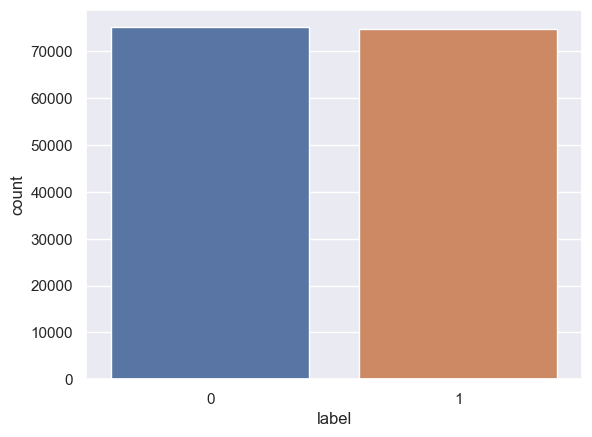

In [5]:
# 훈련 데이터의 라벨 수 확인

sns.set_theme(style='darkgrid')
ax = sns.countplot(x = 'label', data = train_df)

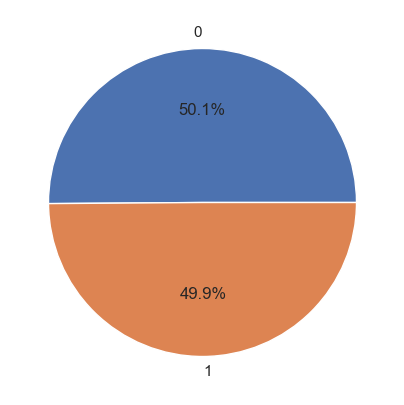

In [6]:
# 훈련데이터 라벨값 비율 확인

labels, frequencies = np.unique(train_df.label.values, return_counts=True)
plt.figure(figsize=(5,5))
plt.pie(frequencies, labels = labels, autopct= '%1.1f%%')
plt.show()

In [7]:
# 결측 값 확인
print(train_df.isnull().sum())

print(test_df.isnull().sum())

id          0
document    5
label       0
dtype: int64
id          0
document    3
label       0
dtype: int64


In [8]:
tokenizer = Komoran() # 한국어 토크나이저를 활용

def preprocess(train_df, test_df):
    train_df.drop_duplicates(subset=['document'], inplace=True) # 중복값 제거
    test_df.drop_duplicates(subset=['document'], inplace=True) # 중복값 제거
    train_df = train_df.dropna() # 결측시 제거
    test_df = test_df.dropna() # 결측시 제거
    print(f"train_df shape => {train_df.shape} \ntest_df shape => {test_df.shape}")
    
    train_df_tokenized = [[token+"/"+POS for token, POS in tokenizer.pos(doc_)] for doc_ in train_df['document']] # 토큰화
    test_df_tokenized = [[token+"/"+POS for token, POS in tokenizer.pos(doc_)] for doc_ in test_df['document']] # 토큰화
    
    exclusion_tags = ['JKS', 'JKC', 'JKG', 'JKO', 'JKB', 'JKV', 'JKQ', 'JX', 'JC',
                      'SF', 'SP', 'SS', 'SE', 'SO', 'EF', 'EP', 'EC', 'ETN', 'ETM',
                      'XSN', 'XSV', 'XSA'] # 불용어 제거(조사, 구두점, 접미사 종류)
    
    f = lambda x: x in exclusion_tags
    
    X_train = []
    for i in range(len(train_df_tokenized)):
        temp = []
        for j in range(len(train_df_tokenized[i])):
            if f(train_df_tokenized[i][j].split('/')[1]) is False:
                temp.append(train_df_tokenized[i][j].split('/')[0])
        X_train.append(temp)
    
    X_test = []
    for i in range(len(test_df_tokenized)):
        temp = []
        for j in range(len(test_df_tokenized[i])):
            if f(test_df_tokenized[i][j].split('/')[1]) is False:
                temp.append(test_df_tokenized[i][j].split('/')[0])
        X_test.append(temp)

    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(30000-4) # 빈도수를 기준으로 30000개 토큰 구축
    vocab = ['<PAD>', '<BOS>', '<UNK>', '<UNUSED>'] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
    
    # 인덱스화

    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in wordlist]
    
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
    
    return X_train, np.array(list(train_df['label'])), X_test, np.array(list(test_df['label'])), word_to_index
X_train, y_train, X_test, y_test, word_to_index = preprocess(train_df, test_df)
index_to_word = {index:word for word, index in word_to_index.items()}

train_df shape => (146182, 3) 
test_df shape => (49157, 3)


In [9]:
all_data = list(X_train)+list(X_test)

num_tokens = [len(tokens) for tokens in all_data]
num_tokens = np.array(num_tokens)

# 평균값, 최댓값, 표준편차
print(f"토큰 길이 평균: {np.mean(num_tokens)}")
print(f"토큰 길이 최대: {np.max(num_tokens)}")
print(f"토큰 길이 표준편차: {np.std(num_tokens)}")

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print(f'설정 최대 길이: {maxlen}')
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 설정값인 {maxlen}에 포함됩니다.')

토큰 길이 평균: 10.763011994532581
토큰 길이 최대: 140
토큰 길이 표준편차: 8.886926944778248
설정 최대 길이: 28
전체 문장의 0.9356554502685076%가 설정값인 28에 포함됩니다.


In [10]:
# pad_sequences를 통해 설정한 길이로 패딩을 진행하였고 계산한 값이 아닌 임의의 값(70)을 지정하고 진행

X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train,
                                                       padding='pre',
                                                       value=word_to_index["<PAD>"],
                                                       maxlen=70)

X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test,
                                                       padding='pre',
                                                       value=word_to_index["<PAD>"],
                                                       maxlen=70)

Part 5. 분류 모델을 훈련하고 적용해 보세요

In [11]:
# 모델링LSTM
# 0과 1의 이진 분류이기 때문에 sigmoid를 활성화 함수로 사용했으며, binart_crossentropy를 사용
# 단어 벡터차원(word_vector_dim)과 LSMC layer의 units는 임의로 조정이 가능한 하이퍼파라미터 값

vocab_size = 30000
word_vector_dim = 16

model = tf.keras.Sequential()
model.add(tf.keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(tf.keras.layers.LSTM(units=8))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 16)          480000    
                                                                 
 lstm (LSTM)                 (None, 8)                 800       
                                                                 
 dense (Dense)               (None, 1)                 9         
                                                                 
Total params: 480809 (1.83 MB)
Trainable params: 480809 (1.83 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [12]:
# 사이킷런의 train_test_split을 활용해 일부 검증 데이터셋을 만들었습니다.

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, shuffle=True,
                                                  stratify=y_train, random_state=777)

In [17]:
# 모델 훈련 과정

history = model.fit(X_train, y_train, epochs=10, batch_size=512,
                    validation_data=(X_val, y_val), verbose=1)

Epoch 1/10
200/200 [==============================] - 5s 24ms/step - loss: 0.2350 - accuracy: 0.9083 - val_loss: 0.4349 - val_accuracy: 0.8243
Epoch 2/10
200/200 [==============================] - 5s 24ms/step - loss: 0.2267 - accuracy: 0.9126 - val_loss: 0.4452 - val_accuracy: 0.8223
Epoch 3/10
200/200 [==============================] - 5s 24ms/step - loss: 0.2194 - accuracy: 0.9158 - val_loss: 0.4588 - val_accuracy: 0.8209
Epoch 4/10
200/200 [==============================] - 5s 24ms/step - loss: 0.2121 - accuracy: 0.9189 - val_loss: 0.4682 - val_accuracy: 0.8185
Epoch 5/10
200/200 [==============================] - 5s 24ms/step - loss: 0.2057 - accuracy: 0.9213 - val_loss: 0.4781 - val_accuracy: 0.8177
Epoch 6/10
200/200 [==============================] - 5s 24ms/step - loss: 0.1987 - accuracy: 0.9236 - val_loss: 0.4922 - val_accuracy: 0.8165
Epoch 7/10
200/200 [==============================] - 5s 24ms/step - loss: 0.1921 - accuracy: 0.9263 - val_loss: 0.5015 - val_accuracy: 0.8161

In [18]:
# test 데이터에 대해 학습한 모델로 평가 진행

predict = model.evaluate(X_test, y_test, verbose=1)
print(predict)

1537/1537 [==============================] - 4s 2ms/step - loss: 0.5408 - accuracy: 0.8109
[0.5407754182815552, 0.8108713030815125]


Part 6. 모델을 평가하세요

In [19]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


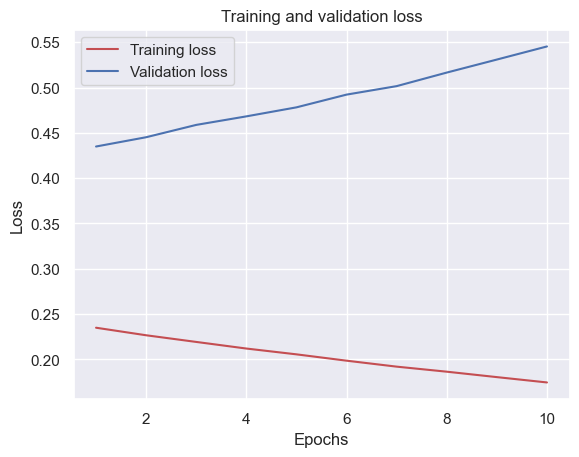

In [20]:
# 모델 훈련 중 각 에포크에 대한 train loss 값과 validation loss 값의 변화를 시각화한 코드

acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()